In [1]:
import matplotlib.pyplot as plt
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms

import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
batch_size = 128

In [30]:
# Data
transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5)
])

train_dataset = datasets.MNIST('./data', transform=transform, download=True)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = datasets.MNIST('./data', transform=transform, download=True, train=False)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [7]:
# utils
def one_hot(x, max_x):
    return torch.eye(max_x+1)[x]

In [6]:
x = torch.tensor([3, 4, 5])
y = torch.tensor([
    [0, 0, 0, 1, 0, 0, 0]
])

In [8]:
def calculate_loss(model, dataloader, loss_fn=nn.MSELoss(), flatten=True,
                  conditional=False):
    losses = []
    for batch, labels in dataloader:
        batch = batch.to(device)
        labels = labels.to(device)
        
        if flatten:
            batch = batch.view(batch.size(0), 28*28)
        if conditional:
            loss = loss_fn(batch, model(batch, labels))
        else:
            loss = loss_fn(batch, model(batch))
        
        losses.append(loss)
    
    return (sum(losses)/len(losses)).item()

In [53]:
def show_visual_progress(model, test_dataloader, row=5, flatten=True,
                         vae=False, conditional=False, title=None):
    if title:
        plt.title(title)
    
    iter(test_dataloader)
    
    image_rows = []
    
    for idx, (batch, label) in enumerate(test_dataloader):
        if row == idx:
            break
        
        batch = batch.to(device)
        if flatten:
            batch = batch.view(batch.size(0), 28*28)
        
        if not conditional:
            images = model(batch).detach().cpu().numpy().reshape(batch.size(0), 28, 28)
        else:
            images = model(batch, label).detach().cpu().numpy().reshape(batch.size(0), 28, 28)
        
        image_idxs = [list(label.numpy()).index(x) for x in range(10)]
        combined_images = np.concatenate([images[x].reshape(28, 28) for x in image_idxs], 1)
        
        image_rows.append(combined_images)
        plt.imshow(np.concatenate(image_rows))
        
        plt.show()

In [54]:
def evaluate(losses, autoencoder, dataloader, flatten=True, vae=False,
             conditional=False):
    if vae and conditional:
        model = lambda x, y: autoencoder(x, y)[0]
    elif vae:
        model = lambda x: autoencoder(x)[0]
    else:
        model = autoencoder
    
    loss = calculate_loss(model, dataloader, flatten=flatten, conditional=conditional)
    show_visual_progress(model, test_dataloader, flatten=flatten, vae=vae, 
                         conditional=conditional)
    losses.append(loss)

In [55]:
def train(net, dataloader, test_dataloader, epochs=5, flatten=False,
          loss_fn=nn.MSELoss()):
    optim = torch.optim.Adam(net.parameters())
    train_losses = []
    validation_losses = []
    for i in range(epochs):
        for batch, labels in dataloader:
            batch = batch.to(device)
            if flatten:
                batch = batch.view(batch.size(0), 28*28)
            
            optim.zero_grad()
            loss = loss_fn(batch, net(batch))
            loss.backward()
            optim.step()
            
            train_losses.append(loss.item())
        
        evaluate(validation_losses, net, test_dataloader, flatten)

In [56]:
def calculate_nparameters(model):
    def times(shape):
        parameters = 1
        for layer in list(shape):
            parameters *= layer
        
        return parameters
    layer_params = [times(x.size()) for x in list(model.parameters())]
    
    return sum(layer_params)

# Vanilla AE

In [57]:
class Autoencoder(nn.Module):
    def __init__(self, input_size, hidden=10):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, hidden))
        
        self.decoder = nn.Sequential(
            nn.Linear(hidden, 128),
            nn.ReLU(),
            nn.Linear(128, 512),
            nn.ReLU(),
            nn.Linear(512, input_size))
    
    def forward(self, x):
        return self.decoder(self.encoder(x))

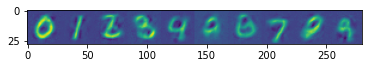

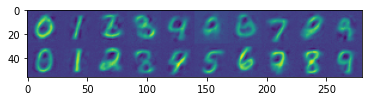

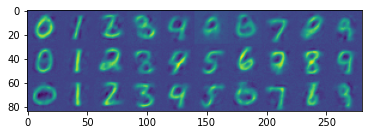

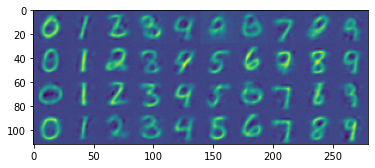

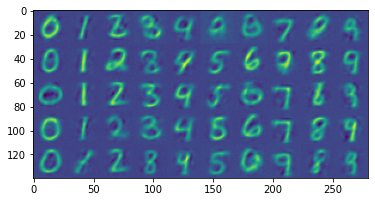

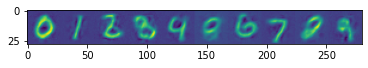

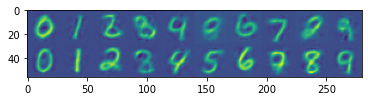

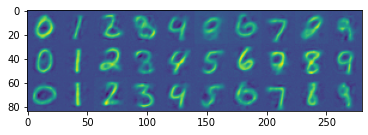

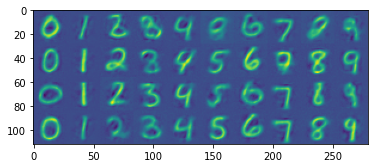

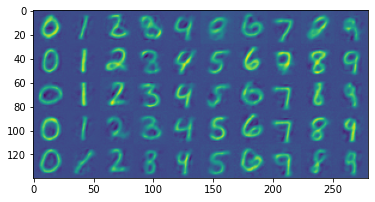

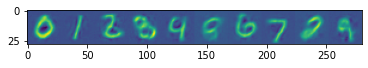

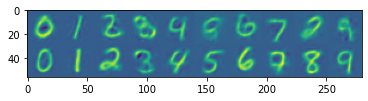

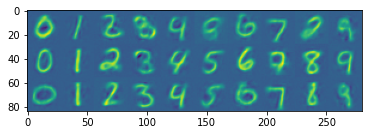

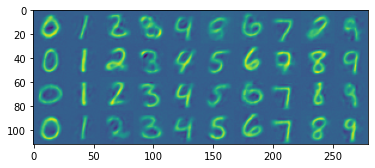

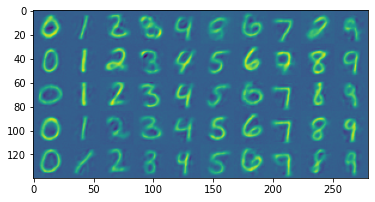

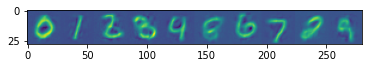

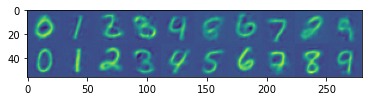

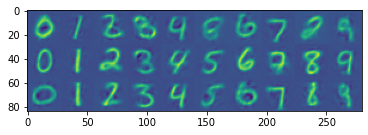

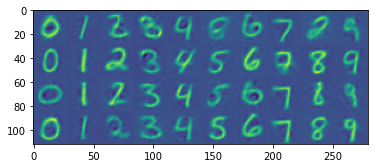

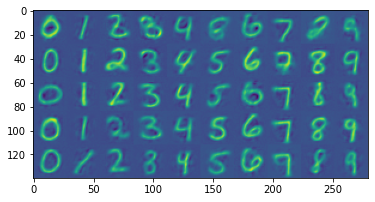

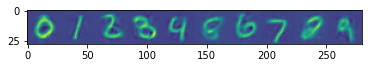

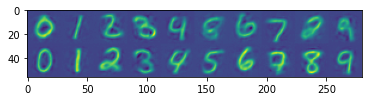

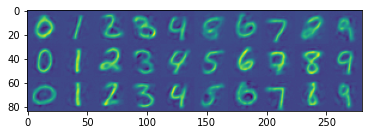

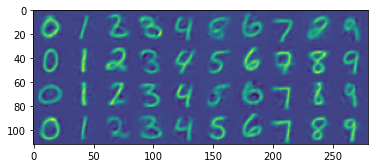

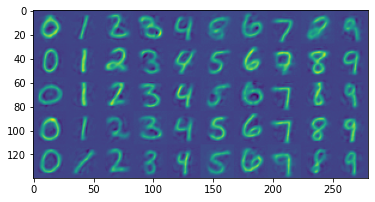

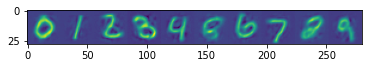

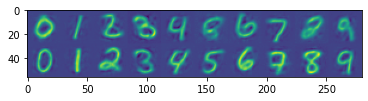

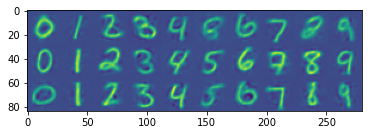

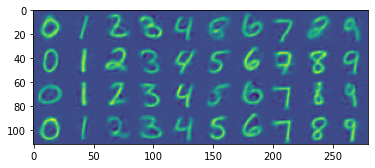

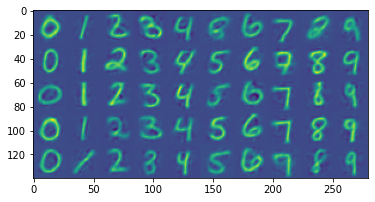

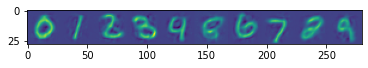

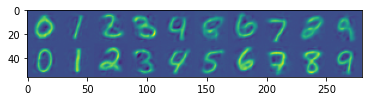

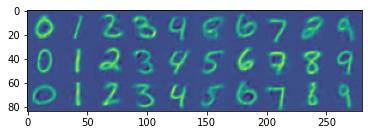

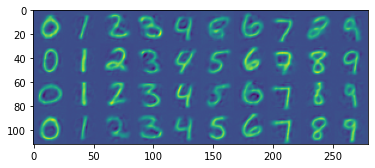

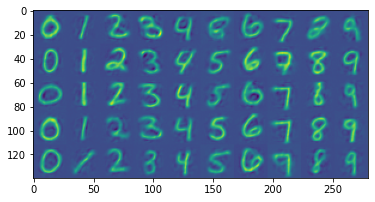

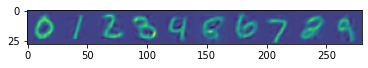

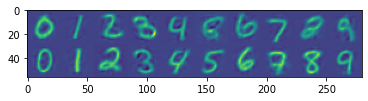

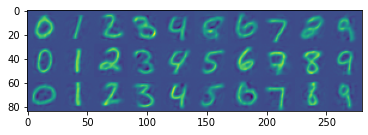

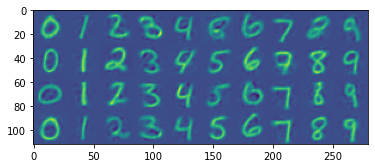

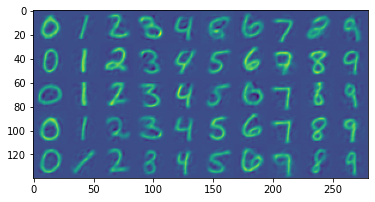

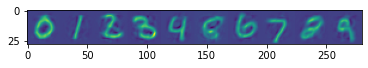

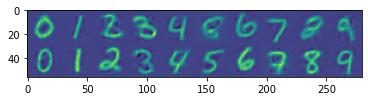

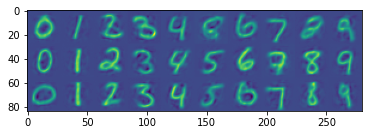

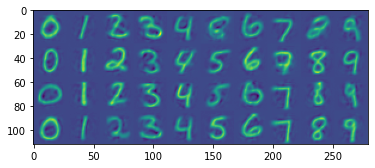

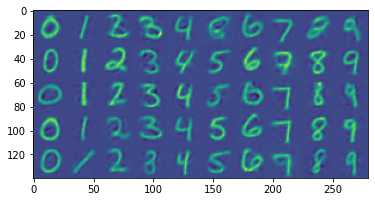

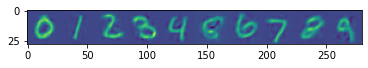

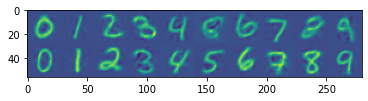

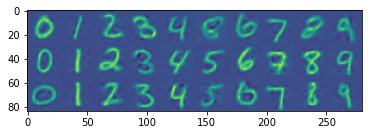

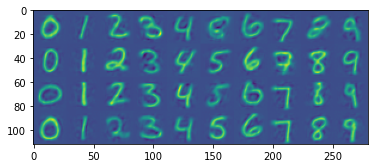

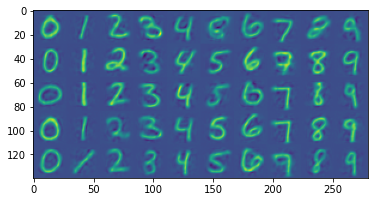

In [58]:
autoencoder = Autoencoder(28*28).to(device)
train(autoencoder, train_dataloader, test_dataloader, epochs=10, flatten=True)

In [35]:
train_dataset[0][0].shape

torch.Size([1, 28, 28])